# Mark II

In [17]:
!pip install parmap

In [1]:
import pandas as pd
import numpy as np
import os 
from Bio import SeqIO
import csv
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import re

from multiprocessing import Pool

num_partitions = 18 #number of partitions to split dataframe
num_cores = 20 #number of cores on your machine


In [2]:
def lengthDistribution(df,title):
    fig = plt.figure()
    ax = fig.gca()
    pd.Series(df['length']).hist(color='blue', bins=200, ax=ax)
    plt.ylabel('Num of Seq with this length ')
    plt.xlabel('Length of Seq')
    plt.title(title)

def plotCharDistribution(dict_counts, char_totalsize, title):
    fig = plt.figure()
    fig.suptitle(title, fontsize=20)
    ax = fig.add_subplot(111)
    # The bar chart, with letters along the horizontal axis and the calculated
    # letter frequencies as percentages as the bar height
    x = range(len(dict_counts))
    letters =  dict_counts.keys()
    ax.bar(x, [val / char_totalsize * 100 for key,val in dict_counts.items()], width=0.8,
        color='g', alpha=0.5, align='center')
    ax.set_xticks(x)
    ax.set_xticklabels(letters)
    ax.tick_params(axis='x', direction='out')
    ax.set_xlim(-0.5, 25.5)
    ax.yaxis.grid(True)
    ax.set_ylabel('Letter frequency, %')

def countProtien(df, title):
    # count Sequence 
    records = df['Sequence']
    print("Count Records:", len(records))
    # countAminoAcids
    counts = Counter()
    for index, row in df.iterrows():
        line= row['Sequence']
        counts.update(line.rstrip())
        total = float(sum(counts.values()))
    sorted_dict = {key: value for key, value in sorted(counts.items())}
    for key,val in sorted_dict.items():
        print("{}: {}, ({:.2%})".format(key,val, val / total))

    plotCharDistribution(sorted_dict, total, title)

## Create Bad list

In [4]:
# construct badlist
amp_uniref_df = pd.read_csv('/mnt/vdb/thesis/uniref50/badlist.ready.nr', sep='\t', header=0)
amp_uniref_df

,ID_Query,ID_Target,sequence_identity,alignment_length,number_of_mismatches,number_of_gap_openings,start-position_in_query,end-position_in_query,start-position_in_target,end-position_in_target,E-value,bit_score
0,UPI0004FCCC5E,UniRef50_K7EXB5,0.984,129,2,0,1,129,1,129,6.466000e-73,246
1,UPI0004FCCC5E,UniRef50_A0A093G9N1,0.961,129,5,0,1,129,1,129,5.383000e-71,241
2,UPI0004FCCC5E,UniRef50_Q16777,0.953,129,6,0,1,129,1,129,1.012000e-70,240
3,UPI0004FCCC5E,UniRef50_Q8IUE6,0.984,125,2,0,1,125,1,125,1.389000e-70,240
4,UPI0004FCCC5E,UniRef50_L7MTL8,0.945,129,7,0,1,129,1,129,2.612000e-70,239
...,...,...,...,...,...,...,...,...,...,...,...,...
7175653,MGYP001013544865,UniRef50_D8LWM1,0.630,100,36,0,22,118,15,114,5.172000e-30,123
7175654,MGYP001013544865,UniRef50_A0A6P7YQR2,0.592,108,44,0,11,118,13,120,3.445000e-29,120
7175655,MGYP001013544865,UniRef50_A0A433DDU2,0.608,118,45,0,4,118,6,123,4.726000e-29,120
7175656,MGYP001013544865,UniRef50_A0A1I8AJC7,0.533,120,55,0,1,119,1,120,3.944000e-27,114


In [5]:
bad_list = list(set(amp_uniref_df[amp_uniref_df['sequence_identity'] >=0.3]['ID_Target'].tolist())) 
len(bad_list)

125698

In [ ]:
bad_list

In [20]:
with open('/mnt/vdb/thesis/uniref50/badlist.sim30.uniq.txt', 'w') as f:
    for item in bad_list:
        f.write("%s\n" % item)

In [23]:
if "UniRef50_B4IPI1" in bad_list:
    print("True")

True


## Begin non-AMP Search

In [3]:
amp_fasta= '/mnt/vdb/thesis/amp_final/ampV4_sim95.ready.fasta'

nonAMPs_csv = "/mnt/vdb/thesis/non_amp/non_AMPs_recal_nr.V3.csv"
uniref50= "/mnt/vdb/thesis/uniref50/uniref50.excludedBadList.len2400.fasta"

In [4]:
with open(amp_fasta) as fasta_file:  # Will close handle cleanly
    identifiers = []
    lengths = []
    sequence = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        sequence.append(str(seq_record.seq))
        lengths.append(len(seq_record.seq))

AMPs_df = pd.DataFrame(list(zip(identifiers, sequence, lengths)), columns =['ID', 'Sequence', 'length']) 
AMPs_df # 127018
# 113354 recal nr

,ID,Sequence,length
0,E22363|Antimicrobial,DAKAGIALSKNFVKL,15
1,UPI0004225091,MAKKLEITLTRSLIGRPEDQRVTVKTLGLGKTNSTVVKEDNAAMRG...,62
2,UPI000897033E,MSRYFRRRKFCRFSAEGVKEIDYKDIATLKNYVTESGKIVPSRITG...,75
3,UPI0005EDACCD,MAISVRKNLVSSSKYSIKCPYSMDAKYITFHNTANDASADAEIRYM...,314
4,MGYP001081318282,MAISVRKNLVASSKYSVKCPYSMDAKYITFHNTANDASADAEIRYM...,314
...,...,...,...
107274,UPI0006B18732,MKKKILAGALVALFLLPINVFAAKGDQGVDWAIYQGDQGRFGYAHD...,421
107275,SwirhisoilCB1_FD_contig_61_2408559_length_255_...,NIVSKRTFQPNNRRRAKTHGFRLRMRTRAGRSILAARRRKGRSELSA,47
107276,UPI00059AA799,MAKKSMINKQQRKAKFSTRAYTRCSICGRPHSVYQDLGICRVCLRK...,61
107277,UPI0002A10FCA,MRFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVEL...,95


In [5]:
df_count=AMPs_df.groupby('length').length.count().reset_index(name='count').sort_values(['count'], ascending=False)
#df_count.to_csv('df_count.csv', index=False)
_tmp_df_count =df_count
_tmp_df_count

,length,count
26,37,1931
81,92,1655
67,78,1168
33,44,1128
73,84,1126
...,...,...
1371,1493,1
1368,1489,1
1367,1488,1
1366,1487,1


In [13]:
any(ele in "MKKKILAGALVALFLLPINVFAAKGDQGVDWAIYQGDQGRFGYAHD" for ele in amp_list) 

False

In [6]:
amp_list = AMPs_df.Sequence.to_list()

In [7]:
# shuffle ID
_tmp_df_count = _tmp_df_count.sample(frac=1).reset_index(drop=True)
_tmp_df_count["count"].values

array([  3,   2,   4, ..., 219, 107,   3])

In [8]:
num_partitions = 24 #number of partitions to split dataframe 22
num_cores = 24 #number of cores on your machine 22

In [12]:
PROTIEN_CODE = "ACDEFGHIKLMNPQRSTVWXY"
regexp  = re.compile("B|Z|J|U|O|X")

In [15]:
from os import getpid

def find_amp(_tmp_df_count):
    process_id =str(getpid())
    nonAMPs_csv = "/mnt/vdb/thesis/non_amp/non_amp."+process_id+".csv"
    NonAMPs_csv = open(nonAMPs_csv, 'w')
    NonAMPs_csv.write('"ID","Sequence","length"'+ '\n')
    print(process_id+" Start")
    record = SeqIO.parse(uniref50, "fasta")
    for seq_record in record:

        if regexp.search(str(seq_record.seq)):  # if contain any non coding , then ignore
            continue
            
        #if str(seq_record.seq) in amp_list: # if duplicate in amp_list, then  ignore
        #    continue
        
        seqLen = len(str(seq_record.seq))
        # update value
        _tmp_row = _tmp_df_count.loc[ _tmp_df_count['length'] == seqLen]
        if not _tmp_row.empty and  _tmp_row['count'].values > 0:
           # print (str(_tmp_row['length']) +" "+ str(_tmp_row['count']))
           # print('"'+str(seq_record.id)+'","'+str(seq_record.seq)+'","'+ str(seqLen)+'"')
            NonAMPs_csv.write('"'+str(seq_record.id)+'","'+str(seq_record.seq)+'","'+ str(seqLen)+'"' + '\n')
            
            _tmp_df_count.at[ _tmp_row.index,'count']= _tmp_row['count'] - 1
        #elif : # shulff seqeunce and subseq
                    
        else:
            if _tmp_df_count['count'].values.sum() == 0:
                print(process_id+" stop: found every range")
                break
    NonAMPs_csv.close()


from functools import partial

def parallelize_dataframe(df, func):
    _tmp_df_split = np.array_split(df, num_partitions)
        
    pool = Pool(num_cores)
    pool.map(func, _tmp_df_split)

    pool.close()
    pool.join()


In [ ]:
parallelize_dataframe(_tmp_df_count, find_amp)

## Merge non-AMPs and Check 

In [19]:
import glob

path = r'/mnt/vdb/thesis/non_amp/' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

nonAMP_df = pd.concat(li, axis=0, ignore_index=True)

In [20]:
nonAMP_df

,ID,Sequence,length
0,UniRef50_I4DNN7,FEASEPQFVDSTEGPVFKKLKLKKTVAPLKQDTSSVTLPKFQLKSR...,335
1,UniRef50_A7S431,DVNECDSEPCQNGGSCTDMGNYYQCACVPGFSGVNCEINDDNCESN...,423
2,UniRef50_A0A2L2YY27,KNPFDEPGKPGNLEVTDWDKDHIDLKWIPPESDGGSPISSYLVEVK...,286
3,UniRef50_E9BFP7,MPTLSSLTVAEQVAALPPLSQLLGIDPPGAANHKTKDTGKAPAWQV...,727
4,UniRef50_UPI001370D270,DPALPAEPTEADRAVASAVDAVIGAIGTVELTEGCRARIDAAQAAY...,335
...,...,...,...
107274,UniRef50_T0LMF4,MEYDITDPINTFRRIDQQTKTN,22
107275,UniRef50_U4L750,MRLRCMAQKVEPQSIIPLGVAV,22
107276,UniRef50_T0K8R7,MNHKQTAKEVLELVGGEKNQGG,22
107277,UniRef50_T0K420,MILLFFSINGTIRFHLSINETS,22


In [21]:
nonAMP_df.drop_duplicates(subset=['Sequence'],inplace=True)
nonAMP_df

,ID,Sequence,length
0,UniRef50_I4DNN7,FEASEPQFVDSTEGPVFKKLKLKKTVAPLKQDTSSVTLPKFQLKSR...,335
1,UniRef50_A7S431,DVNECDSEPCQNGGSCTDMGNYYQCACVPGFSGVNCEINDDNCESN...,423
2,UniRef50_A0A2L2YY27,KNPFDEPGKPGNLEVTDWDKDHIDLKWIPPESDGGSPISSYLVEVK...,286
3,UniRef50_E9BFP7,MPTLSSLTVAEQVAALPPLSQLLGIDPPGAANHKTKDTGKAPAWQV...,727
4,UniRef50_UPI001370D270,DPALPAEPTEADRAVASAVDAVIGAIGTVELTEGCRARIDAAQAAY...,335
...,...,...,...
107274,UniRef50_T0LMF4,MEYDITDPINTFRRIDQQTKTN,22
107275,UniRef50_U4L750,MRLRCMAQKVEPQSIIPLGVAV,22
107276,UniRef50_T0K8R7,MNHKQTAKEVLELVGGEKNQGG,22
107277,UniRef50_T0K420,MILLFFSINGTIRFHLSINETS,22


In [22]:
nonAMP_df.length.describe()

count    107279.000000
mean        207.602439
std         273.890325
min          11.000000
25%          61.000000
50%          93.000000
75%         214.000000
max        2337.000000
Name: length, dtype: float64

Count Records: 107279
A: 1805788, (8.11%)
C: 376046, (1.69%)
D: 1236316, (5.55%)
E: 1454717, (6.53%)
F: 812849, (3.65%)
G: 1518289, (6.82%)
H: 525823, (2.36%)
I: 1103887, (4.96%)
K: 1199164, (5.38%)
L: 2069303, (9.29%)
M: 525913, (2.36%)
N: 928743, (4.17%)
P: 1146938, (5.15%)
Q: 915722, (4.11%)
R: 1285636, (5.77%)
S: 1757212, (7.89%)
T: 1288993, (5.79%)
V: 1426321, (6.40%)
W: 273869, (1.23%)
Y: 619853, (2.78%)


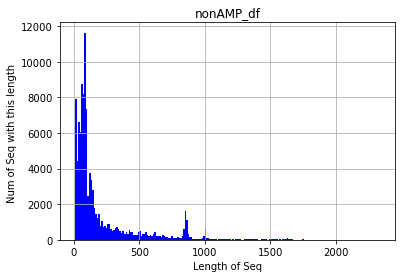

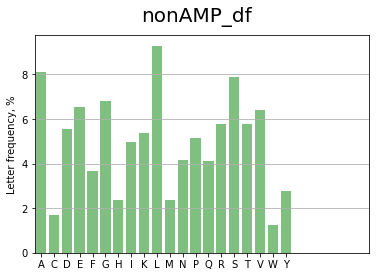

In [23]:
lengthDistribution(nonAMP_df,"nonAMP_df")
countProtien(nonAMP_df,"nonAMP_df")

In [24]:
### non AMP to FASTA (optional)

with open("/mnt/vdb/thesis/non_amp/NonAMPs.V4_sim95.ready.fasta", 'w') as file:
    for index, row in nonAMP_df.iterrows():
        header = row['ID']
        seq = row['Sequence']
        # print(header)
        file.write('>'+ header + '\n')
        file.write(seq + '\n')
           
print("--- End of Writing ----")

--- End of Writing ----


## Wirte to file

In [25]:
nonAMP_df['class']=1
AMPs_df['class']=0

In [26]:
ready_df = pd.concat([AMPs_df,nonAMP_df], axis=0)
ready_df

,ID,Sequence,length,class
0,E22363|Antimicrobial,DAKAGIALSKNFVKL,15,0
1,UPI0004225091,MAKKLEITLTRSLIGRPEDQRVTVKTLGLGKTNSTVVKEDNAAMRG...,62,0
2,UPI000897033E,MSRYFRRRKFCRFSAEGVKEIDYKDIATLKNYVTESGKIVPSRITG...,75,0
3,UPI0005EDACCD,MAISVRKNLVSSSKYSIKCPYSMDAKYITFHNTANDASADAEIRYM...,314,0
4,MGYP001081318282,MAISVRKNLVASSKYSVKCPYSMDAKYITFHNTANDASADAEIRYM...,314,0
...,...,...,...,...
107274,UniRef50_T0LMF4,MEYDITDPINTFRRIDQQTKTN,22,1
107275,UniRef50_U4L750,MRLRCMAQKVEPQSIIPLGVAV,22,1
107276,UniRef50_T0K8R7,MNHKQTAKEVLELVGGEKNQGG,22,1
107277,UniRef50_T0K420,MILLFFSINGTIRFHLSINETS,22,1


In [27]:
ready_df.drop_duplicates(subset=['Sequence'],inplace=True)
print(len(ready_df[ready_df["class"] == 0]))
print(len(ready_df[ready_df["class"] == 1]))
ready_df

107279
106997


,ID,Sequence,length,class
0,E22363|Antimicrobial,DAKAGIALSKNFVKL,15,0
1,UPI0004225091,MAKKLEITLTRSLIGRPEDQRVTVKTLGLGKTNSTVVKEDNAAMRG...,62,0
2,UPI000897033E,MSRYFRRRKFCRFSAEGVKEIDYKDIATLKNYVTESGKIVPSRITG...,75,0
3,UPI0005EDACCD,MAISVRKNLVSSSKYSIKCPYSMDAKYITFHNTANDASADAEIRYM...,314,0
4,MGYP001081318282,MAISVRKNLVASSKYSVKCPYSMDAKYITFHNTANDASADAEIRYM...,314,0
...,...,...,...,...
107274,UniRef50_T0LMF4,MEYDITDPINTFRRIDQQTKTN,22,1
107275,UniRef50_U4L750,MRLRCMAQKVEPQSIIPLGVAV,22,1
107276,UniRef50_T0K8R7,MNHKQTAKEVLELVGGEKNQGG,22,1
107277,UniRef50_T0K420,MILLFFSINGTIRFHLSINETS,22,1


In [28]:
ready_df.to_csv("/mnt/vdb/thesis/AMP_NonAMPs.V4_sim95.ready.csv",sep=",", quotechar='"',index=False, quoting=csv.QUOTE_ALL)

In [ ]:
ready_df.to_csv("../datasets/thesis/AMP_NonAMPs.ready.csv",sep=",", quotechar='"',index=False, quoting=csv.QUOTE_ALL)

# Recalibrate between two set   (Start on dataset V3. recal)

In [20]:
# remove ambigous 
NON_CODE = "B|Z|J|U|O|X"
nonAMP_df = nonAMP_df[~nonAMP_df["Sequence"].str.contains(NON_CODE, regex=True)]
nonAMP_df

,ID,Sequence,length
0,UniRef50_A7RGL2,EESEDEDKDVVLKSDAITKYYTIKDELGKGRFGVVCKCVNKKTGKQ...,311
1,UniRef50_S4NVH8,PSNPPVFTKKMQPCRVFEHEQARFEVEFDGDPLPTIKWYRENFPIK...,75
2,UniRef50_A0A0S7JAH0,MQLSGGNPRLNQLCARWQQVWLLALDRQRKLNDALDRQEELKEFAN...,282
3,UniRef50_A0A1V3ZYL8,HAGIDPTTLHGTDTAVFTGVMAQEYGPRLYEPSQGTDGYLLTGNTS...,374
4,UniRef50_F6V062,MVDTPEMVRARENQSFLSQVNYKSDVESMKGRNHSTILDTPELRQV...,374
...,...,...,...
127013,UniRef50_U4KZ92,MHLEFNRARAEYQSTPCATKPFLWL,25
127014,UniRef50_F6KAZ0,MQFFIFVSILCLFLENVGAFYMYSS,25
127015,UniRef50_A0A2S4WHR4,MGNMFLIRPMEASHSSASGVPSLCG,25
127016,UniRef50_A0A0G4NLI8,HHALAPLPRNRHHVARRPRRRRPPR,25


In [21]:
AMPs_df = AMPs_df[~AMPs_df["Sequence"].str.contains(NON_CODE, regex=True)]
AMPs_df

,ID,Sequence,length
0,EN92515250|C|B3FJD7|phage,MAKKSVPLRKPAGSDGQGNIKVPGGPVVLDLGDFDDIFGPMESESP...,2337
1,EN54061055|C|F8SJ56|phage,MASKKTTLPKPKGINPQGSIVQLDLDDFDDLFDEDFGLPKKNSPYT...,2319
2,EN4815120|C|Q8SCY1|phage,MAKKVTLPKGQTGATGTTLGQAGNILDLSDVDDIFGDTPKAKKGSP...,2237
3,EN3016141|D|D2J8A7|bacteriocin,MAETIKGLRIDLSLKDMGVGRSITELKRSFRTLNSDLKVSSKNFEY...,1619
4,EN9175723|BD|Q93IM3|bacteriocin,MAKKKNTYKVPSIIALTLAGTALTTHHAQAADKTQDQSTNKNILND...,1564
...,...,...,...
127013,MGYP001502946729,MKVMASVKKICRNCKVIKRRGVVRVICTDPRHKQRQG,37
127014,MGYP001502959890,MAHKKGASSSRNGRDSNAKRLGVKRFGGQLVNAGEILVRQRGTHFH...,84
127015,MGYP001502962667,MELVELLFRAEKRLSGLHPLVADKARALIRKAYEEGIYIIITQGFR...,156
127016,MGYP000753212479,MPRSLKKGPFVDHHLLSKVLSAVEANLKKPIKTWSRRSMIIPDMIG...,91


### remove residual similarities 
```bash
# mmseqs with high sensitivites
mmseqs easy-search  /mnt/vdb/thesis/non_amp/NonAMPs.final.ready.fasta /mnt/vdb/thesis/amp_final/ampV3.ready.fasta  data.mmseq.nr tmp 

#
echo -e "ID_Query\tID_Target\tsequence_identity\talignment_length\tnumber_of_mismatches\tnumber_of_gap_openings\tstart-position_in_query\tend-position_in_query\tstart-position_in_target\tend-position_in_target\tE-value\tbit_score" | cat - data.mmseq.nr > data.ready.mmseq.nr
#
awk '{ if ($3 >= 0.3) { print $1 " " $2 } }' data.ready.mmseq.nr > sim30.txt

# result
# data.mmseq.nr  data.ready.mmseq.nr  sim30.txt  sim80.txt  sim_less30.txt
```

In [16]:
res_list_df =  pd.read_csv("/mnt/vdb/thesis/amp_final/sim30.txt",sep='\t',header=0)

In [29]:
nonAMP_df = nonAMP_df[~nonAMP_df['ID'].isin(res_list_df["ID_Query"].tolist())]
nonAMP_df

,ID,Sequence,length
0,UniRef50_A7RGL2,EESEDEDKDVVLKSDAITKYYTIKDELGKGRFGVVCKCVNKKTGKQ...,311
1,UniRef50_S4NVH8,PSNPPVFTKKMQPCRVFEHEQARFEVEFDGDPLPTIKWYRENFPIK...,75
2,UniRef50_A0A0S7JAH0,MQLSGGNPRLNQLCARWQQVWLLALDRQRKLNDALDRQEELKEFAN...,282
3,UniRef50_A0A1V3ZYL8,HAGIDPTTLHGTDTAVFTGVMAQEYGPRLYEPSQGTDGYLLTGNTS...,374
4,UniRef50_F6V062,MVDTPEMVRARENQSFLSQVNYKSDVESMKGRNHSTILDTPELRQV...,374
...,...,...,...
127013,UniRef50_U4KZ92,MHLEFNRARAEYQSTPCATKPFLWL,25
127014,UniRef50_F6KAZ0,MQFFIFVSILCLFLENVGAFYMYSS,25
127015,UniRef50_A0A2S4WHR4,MGNMFLIRPMEASHSSASGVPSLCG,25
127016,UniRef50_A0A0G4NLI8,HHALAPLPRNRHHVARRPRRRRPPR,25


## Labeling 

In [30]:
# setup
nonAMP_df['class']=1
AMPs_df['class']=0

In [47]:
nonAMP_df.drop_duplicates(subset=['Sequence'],inplace=True)
nonAMP_df

,ID,Sequence,length,class
0,UniRef50_A7RGL2,EESEDEDKDVVLKSDAITKYYTIKDELGKGRFGVVCKCVNKKTGKQ...,311,1
1,UniRef50_S4NVH8,PSNPPVFTKKMQPCRVFEHEQARFEVEFDGDPLPTIKWYRENFPIK...,75,1
2,UniRef50_A0A0S7JAH0,MQLSGGNPRLNQLCARWQQVWLLALDRQRKLNDALDRQEELKEFAN...,282,1
3,UniRef50_A0A1V3ZYL8,HAGIDPTTLHGTDTAVFTGVMAQEYGPRLYEPSQGTDGYLLTGNTS...,374,1
4,UniRef50_F6V062,MVDTPEMVRARENQSFLSQVNYKSDVESMKGRNHSTILDTPELRQV...,374,1
...,...,...,...,...
127013,UniRef50_U4KZ92,MHLEFNRARAEYQSTPCATKPFLWL,25,1
127014,UniRef50_F6KAZ0,MQFFIFVSILCLFLENVGAFYMYSS,25,1
127015,UniRef50_A0A2S4WHR4,MGNMFLIRPMEASHSSASGVPSLCG,25,1
127016,UniRef50_A0A0G4NLI8,HHALAPLPRNRHHVARRPRRRRPPR,25,1


In [48]:
AMPs_df.drop_duplicates(subset=['Sequence'],inplace=True)
AMPs_df

,ID,Sequence,length,class
0,EN92515250|C|B3FJD7|phage,MAKKSVPLRKPAGSDGQGNIKVPGGPVVLDLGDFDDIFGPMESESP...,2337,0
1,EN54061055|C|F8SJ56|phage,MASKKTTLPKPKGINPQGSIVQLDLDDFDDLFDEDFGLPKKNSPYT...,2319,0
2,EN4815120|C|Q8SCY1|phage,MAKKVTLPKGQTGATGTTLGQAGNILDLSDVDDIFGDTPKAKKGSP...,2237,0
3,EN3016141|D|D2J8A7|bacteriocin,MAETIKGLRIDLSLKDMGVGRSITELKRSFRTLNSDLKVSSKNFEY...,1619,0
4,EN9175723|BD|Q93IM3|bacteriocin,MAKKKNTYKVPSIIALTLAGTALTTHHAQAADKTQDQSTNKNILND...,1564,0
...,...,...,...,...
127013,MGYP001502946729,MKVMASVKKICRNCKVIKRRGVVRVICTDPRHKQRQG,37,0
127014,MGYP001502959890,MAHKKGASSSRNGRDSNAKRLGVKRFGGQLVNAGEILVRQRGTHFH...,84,0
127015,MGYP001502962667,MELVELLFRAEKRLSGLHPLVADKARALIRKAYEEGIYIIITQGFR...,156,0
127016,MGYP000753212479,MPRSLKKGPFVDHHLLSKVLSAVEANLKKPIKTWSRRSMIIPDMIG...,91,0


In [49]:
ready_df = pd.concat([AMPs_df,nonAMP_df], axis=0)
ready_df

,ID,Sequence,length,class
0,EN92515250|C|B3FJD7|phage,MAKKSVPLRKPAGSDGQGNIKVPGGPVVLDLGDFDDIFGPMESESP...,2337,0
1,EN54061055|C|F8SJ56|phage,MASKKTTLPKPKGINPQGSIVQLDLDDFDDLFDEDFGLPKKNSPYT...,2319,0
2,EN4815120|C|Q8SCY1|phage,MAKKVTLPKGQTGATGTTLGQAGNILDLSDVDDIFGDTPKAKKGSP...,2237,0
3,EN3016141|D|D2J8A7|bacteriocin,MAETIKGLRIDLSLKDMGVGRSITELKRSFRTLNSDLKVSSKNFEY...,1619,0
4,EN9175723|BD|Q93IM3|bacteriocin,MAKKKNTYKVPSIIALTLAGTALTTHHAQAADKTQDQSTNKNILND...,1564,0
...,...,...,...,...
127013,UniRef50_U4KZ92,MHLEFNRARAEYQSTPCATKPFLWL,25,1
127014,UniRef50_F6KAZ0,MQFFIFVSILCLFLENVGAFYMYSS,25,1
127015,UniRef50_A0A2S4WHR4,MGNMFLIRPMEASHSSASGVPSLCG,25,1
127016,UniRef50_A0A0G4NLI8,HHALAPLPRNRHHVARRPRRRRPPR,25,1


In [50]:
ready_df["Sequence"] = ready_df["Sequence"].astype(str)
dup_def = ready_df[ready_df.duplicated(subset=['Sequence'])]

In [51]:
dup_def

,ID,Sequence,length,class
10786,UniRef50_P56918,LLPILGNLLNGLL,13,1
10914,UniRef50_P56919,LLPIVGNLLNSLL,13,1
12794,UniRef50_P83412,HGVSGHGQHGVHG,13,1
12799,UniRef50_P82386,GLFDIIKKIAESI,13,1
12802,UniRef50_P84211,QSFGNQWARGHFM,13,1
...,...,...,...,...
120562,UniRef50_P0DTV6,GLVGTLLGHIGKAILS,16,1
120566,UniRef50_C0HJB7,RAGLKFPVGRVHRLLR,16,1
120603,UniRef50_P86127,IIEKLVNTALGLLSGL,16,1
120612,UniRef50_P0DTU0,FLPIVGKSLSGLSGKL,16,1


In [52]:
ready_df.drop_duplicates(subset=['Sequence'],inplace=True)
ready_df

,ID,Sequence,length,class
0,EN92515250|C|B3FJD7|phage,MAKKSVPLRKPAGSDGQGNIKVPGGPVVLDLGDFDDIFGPMESESP...,2337,0
1,EN54061055|C|F8SJ56|phage,MASKKTTLPKPKGINPQGSIVQLDLDDFDDLFDEDFGLPKKNSPYT...,2319,0
2,EN4815120|C|Q8SCY1|phage,MAKKVTLPKGQTGATGTTLGQAGNILDLSDVDDIFGDTPKAKKGSP...,2237,0
3,EN3016141|D|D2J8A7|bacteriocin,MAETIKGLRIDLSLKDMGVGRSITELKRSFRTLNSDLKVSSKNFEY...,1619,0
4,EN9175723|BD|Q93IM3|bacteriocin,MAKKKNTYKVPSIIALTLAGTALTTHHAQAADKTQDQSTNKNILND...,1564,0
...,...,...,...,...
127013,UniRef50_U4KZ92,MHLEFNRARAEYQSTPCATKPFLWL,25,1
127014,UniRef50_F6KAZ0,MQFFIFVSILCLFLENVGAFYMYSS,25,1
127015,UniRef50_A0A2S4WHR4,MGNMFLIRPMEASHSSASGVPSLCG,25,1
127016,UniRef50_A0A0G4NLI8,HHALAPLPRNRHHVARRPRRRRPPR,25,1


In [56]:
print(len(ready_df[ready_df["class"] == 0]))
print(len(ready_df[ready_df["class"] == 1]))

116760
125293


In [77]:
suppop = ready_df["ID"][ready_df["class"] == 1].sample(n=8533, random_state=42)
new_ready_df = ready_df[~ready_df['ID'].isin(suppop)]

In [79]:
print(len(new_ready_df[new_ready_df["class"] == 0]))
print(len(new_ready_df[new_ready_df["class"] == 1]))

116760
116760


In [80]:
# T test 
#A large t-score tells you that the groups are different.
#A small t-score tells you that the groups are similar.

# t-statistic is greater than the critical t-value
# the test concludes that there is a statistically significant difference between 
# the two populations. Therefore, you reject the null hypothesis 
# that there is no statistically significant difference between the two populations.

# If there is no statistically significant difference between the two populations.
# The test fails to reject the null hypothesis and we accept the alternate hypothesis

# nuLL
# h

## Import the packages
import numpy as np
from scipy import stats


## Define 2 random distributions
#Sample Size


a = new_ready_df[new_ready_df["class"] == 0]
b = new_ready_df[new_ready_df["class"] == 1]

### You can see that after comparing the t statistic with the critical t value (computed internally) we get a good p value of 0.0005 and thus we reject the null hypothesis and thus it proves that the mean of the two distributions are different and statistically significant.


## Cross Checking with the internal scipy function
t2, p2 = stats.ttest_ind(a["length"],b["length"])
print("t = " + str(t2))
print("p = " + str(p2))

t = -7.818919922748598
p = 5.34990144263703e-15


In [81]:
from collections import namedtuple

import numpy as np
import scipy.stats as st

TtestResults = namedtuple("Ttest", "T p")
def t_welch(x, y, tails=2):
    """
    Welch's t-test for two unequal-size samples, not assuming equal variances
    """
    assert tails in (1,2), "invalid: tails must be 1 or 2, found %s"%str(tails)
    x, y = np.asarray(x), np.asarray(y)
    nx, ny = x.size, y.size
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    df = ((vx/nx + vy/ny)**2 / # Welch-Satterthwaite equation
            ((vx/nx)**2 / (nx - 1) + (vy/ny)**2 / (ny - 1)))
    t_obs = (x.mean() - y.mean()) / np.sqrt(vx/nx + vy/ny)
    p_value = tails * st.t.sf(abs(t_obs), df)
    return TtestResults(t_obs, p_value)

t_welch(a["length"],b["length"])

Ttest(T=-7.818919922748598, p=5.349902720157315e-15)

In [82]:
ready_df.to_csv("/mnt/vdb/thesis/AMP_NonAMPs.recal.ready.csv",sep=",", quotechar='"',index=False, quoting=csv.QUOTE_ALL)

In [21]:
ready_df.to_csv("../datasets/thesis/AMP_NonAMPs.ready.csv",sep=",", quotechar='"',index=False, quoting=csv.QUOTE_ALL)